In [1]:
import lomap

lomap_mols = lomap.DBMolecules('./molecules', output=True, radial=True)

strict, loose = lomap_mols.build_matrices()

strict = strict.to_numpy_2D_array()

print(strict)

[[0.         0.20189652 0.90483742 0.74081822 0.81873075 0.77880078
  0.52204578 0.22313016 0.54881164 0.54881164]
 [0.20189652 0.         0.22313016 0.27253179 0.24659696 0.23457029
  0.67032005 0.27253179 0.67032005 0.67032005]
 [0.90483742 0.22313016 0.         0.81873075 0.90483742 0.86070798
  0.4965853  0.24659696 0.60653066 0.4965853 ]
 [0.74081822 0.27253179 0.81873075 0.         0.74081822 0.70468809
  0.27253179 0.20189652 0.4965853  0.27253179]
 [0.81873075 0.24659696 0.90483742 0.74081822 0.         0.95122942
  0.30119421 0.27253179 0.67032005 0.30119421]
 [0.77880078 0.23457029 0.86070798 0.70468809 0.95122942 0.
  0.52204578 0.25924026 0.63762815 0.52204578]
 [0.52204578 0.67032005 0.4965853  0.27253179 0.30119421 0.52204578
  0.         0.33287108 0.81873075 0.95122942]
 [0.22313016 0.27253179 0.24659696 0.20189652 0.27253179 0.25924026
  0.33287108 0.         0.40656966 0.33287108]
 [0.54881164 0.67032005 0.60653066 0.4965853  0.67032005 0.63762815
  0.81873075 0.40656

In [2]:
import openfe
import os
from rdkit import Chem
import numpy as np
import itertools

# load molecules in the same order as Lomap did
fnames = [os.path.join('molecules', lomap_mols[i].getName())
          for i in range(10)]

smallmols = []
for fname in fnames:
    if 'mol2' in fname:
        m = Chem.MolFromMol2File(fname, removeHs=False)
    else:
        m = Chem.MolFromMolFile(fname, removeHs=False)
    # OpenFE lightly wraps rdkit molecules
    # to make them hashable and immutable
    smallmols.append(openfe.SmallMoleculeComponent.from_rdkit(m))

# Atom Mappers
## Lomap Mapper

Score is 0.6321205588285577


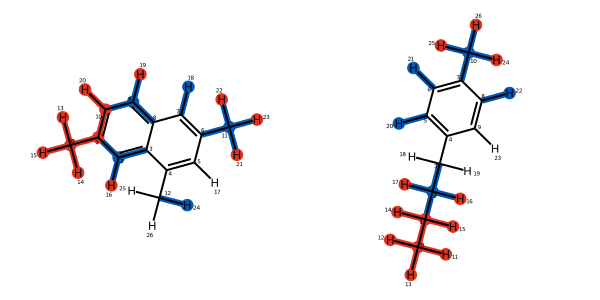

In [3]:
# LomapAtomMapper wraps the lomap.mcs.MCS object
mapper = openfe.LomapAtomMapper()
scorer = openfe.lomap_scorers.default_lomap_score

molA = smallmols[0]
molB = smallmols[1]

# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
lomap_mapping = next(mapper.suggest_mappings(molA, molB))

print(f"Score is {scorer(lomap_mapping)}")

lomap_mapping

## Perses Mapper

Molecules do not appear to share a common scaffold.
Proceeding with direct mapping of molecules, but please check atom mapping and the geometry of the ligands.


Score is 0.7534030360583935


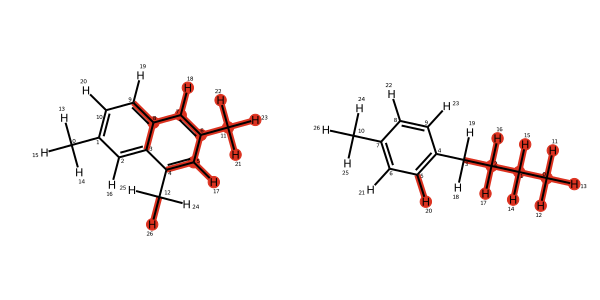

In [4]:
# LomapAtomMapper wraps the lomap.mcs.MCS object
mapper = openfe.PersesAtomMapper()
#scorer = openfe.setup.lomap_scorers.default_lomap_score

molA = smallmols[0]
molB = smallmols[1]

# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
perses_mapping = next(mapper.suggest_mappings(molA, molB))

print(f"Score is {scorer(perses_mapping)}")

perses_mapping